In [1]:
import os
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [2]:
batch_size = 64
num_workers = 0

transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
train_set = './dataset/Train/'
valid_set = './dataset/Test/'


train_data = datasets.ImageFolder(train_set, transform=transform)
valid_data = datasets.ImageFolder(valid_set, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': valid_loader
}

In [4]:
class_names = ['Fire', 'Neutral', 'Smoke']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

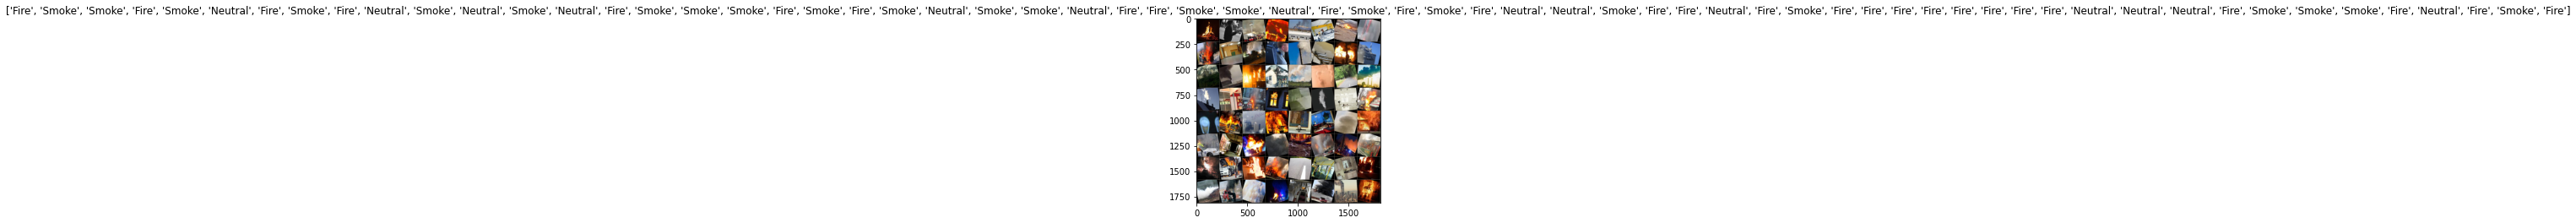

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
model = models.resnet50(pretrained=True)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048,128),
                                      torch.nn.ReLU(),
                                       torch.nn.Linear(128,3),
                                       torch.nn.Softmax()
                                      )

for param in model.fc.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model.cuda()
    
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.fc.parameters(), lr=0.0005)

In [17]:
n_epochs = 100

train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []

def train(n_epochs, loader, model, optimizer, criterion, use_cuda, save_path):
    
    valid_loss_min = np.Inf
       
    for epoch in range(1, (n_epochs+1)):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_acc = train_acc + torch.sum(preds == target.data)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            
            valid_acc = valid_acc + torch.sum(preds == target.data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        train_acc = train_acc/len(loaders['train'].dataset)
        valid_acc = valid_acc/len(loaders['valid'].dataset)
        
        train_accuracy_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
        
        print('Epoch: {} \tTraining Acc: {:6f} \tTraining Loss: {:6f} \tValidation Acc: {:6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_acc,
            train_loss,
            valid_acc,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss  
            
    return model

In [18]:
model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, './trained-models/model_transfer.pt')

/home/ayush/anaconda3/envs/python36/lib/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Acc: 0.796296 	Training Loss: 0.000294 	Validation Acc: 0.866667 	Validation Loss: 0.002338
Validation loss decreased (inf --> 0.002338).  Saving model ...
Epoch: 2 	Training Acc: 0.868519 	Training Loss: 0.000257 	Validation Acc: 0.883333 	Validation Loss: 0.002328
Validation loss decreased (0.002338 --> 0.002328).  Saving model ...
Epoch: 3 	Training Acc: 0.884074 	Training Loss: 0.000250 	Validation Acc: 0.876667 	Validation Loss: 0.002248
Validation loss decreased (0.002328 --> 0.002248).  Saving model ...
Epoch: 4 	Training Acc: 0.891481 	Training Loss: 0.000247 	Validation Acc: 0.893333 	Validation Loss: 0.002287
Epoch: 5 	Training Acc: 0.894074 	Training Loss: 0.000244 	Validation Acc: 0.883333 	Validation Loss: 0.002243
Validation loss decreased (0.002248 --> 0.002243).  Saving model ...
Epoch: 6 	Training Acc: 0.910741 	Training Loss: 0.000240 	Validation Acc: 0.893333 	Validation Loss: 0.002194
Validation loss decreased (0.002243 --> 0.002194).  Saving mode

Epoch: 71 	Training Acc: 0.916667 	Training Loss: 0.000234 	Validation Acc: 0.880000 	Validation Loss: 0.002237
Epoch: 72 	Training Acc: 0.926667 	Training Loss: 0.000232 	Validation Acc: 0.866667 	Validation Loss: 0.002268
Epoch: 73 	Training Acc: 0.901111 	Training Loss: 0.000239 	Validation Acc: 0.883333 	Validation Loss: 0.002226
Epoch: 74 	Training Acc: 0.919630 	Training Loss: 0.000233 	Validation Acc: 0.903333 	Validation Loss: 0.002165
Epoch: 75 	Training Acc: 0.912963 	Training Loss: 0.000235 	Validation Acc: 0.863333 	Validation Loss: 0.002281
Epoch: 76 	Training Acc: 0.914444 	Training Loss: 0.000235 	Validation Acc: 0.900000 	Validation Loss: 0.002186
Epoch: 77 	Training Acc: 0.918519 	Training Loss: 0.000233 	Validation Acc: 0.883333 	Validation Loss: 0.002222
Epoch: 78 	Training Acc: 0.923333 	Training Loss: 0.000233 	Validation Acc: 0.883333 	Validation Loss: 0.002212
Epoch: 79 	Training Acc: 0.917037 	Training Loss: 0.000234 	Validation Acc: 0.896667 	Validation Loss: 0

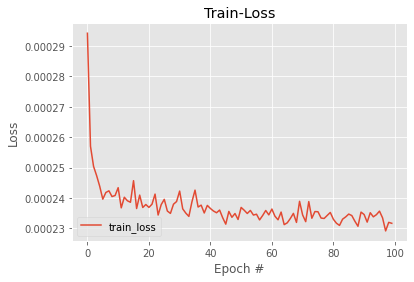

In [24]:
plt.style.use("ggplot")
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.title("Train-Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

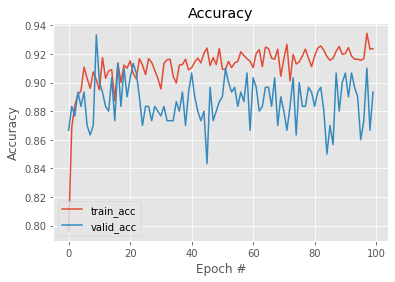

In [29]:

plt.style.use("ggplot")
plt.figure()

plt.plot(train_accuracy_list, label="train_acc")
plt.plot(valid_accuracy_list, label="valid_acc")

plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [30]:
torch.save(model, './trained-models/model_final.pth')

In [49]:
from PIL import Image

class_names = class_names = ['Fire', 'Neutral', 'Smoke']

def predict(image):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    image = image.cuda()

    pred = model(image)
    idx = torch.argmax(pred)
    prob = pred[0][idx].item()*100
    
    return class_names[idx], prob

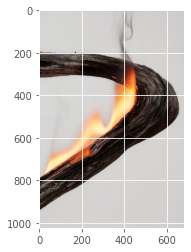

Fire 98.37146401405334


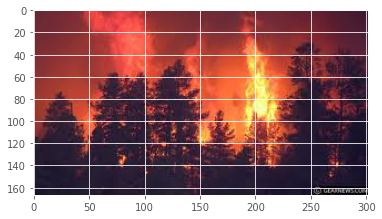

Fire 100.0


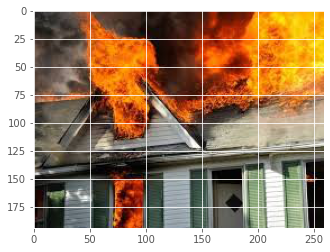

Fire 100.0


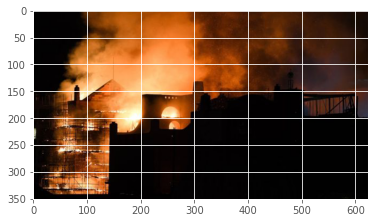

Fire 98.8549530506134


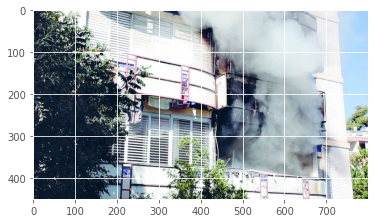

Smoke 100.0


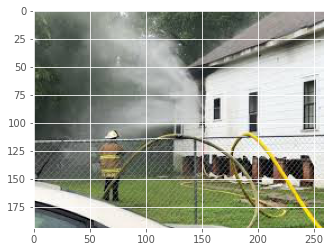

Smoke 99.99969005584717


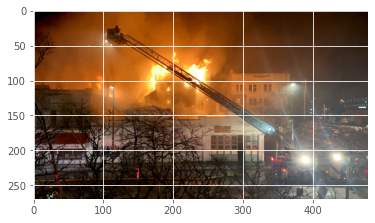

Fire 99.99995231628418


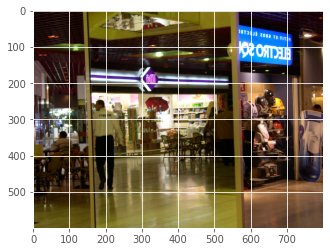

Neutral 100.0


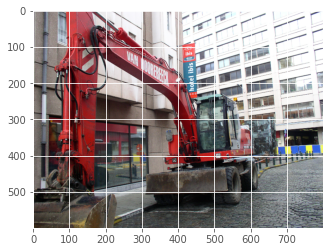

Neutral 57.175761461257935


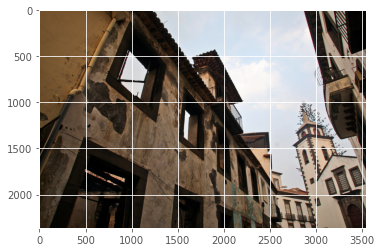

Neutral 99.99998807907104


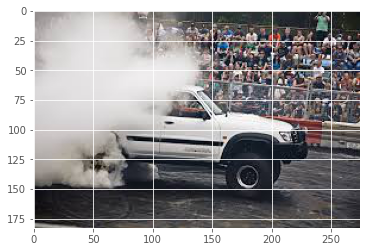

Smoke 99.99997615814209


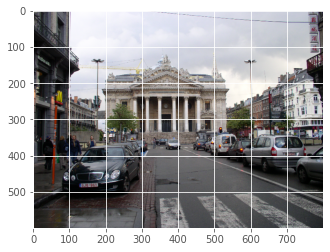

Neutral 100.0


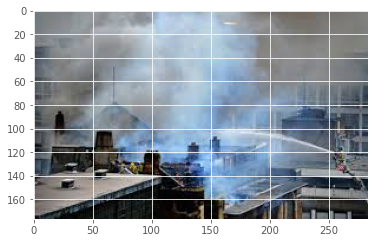

Smoke 99.99840259552002


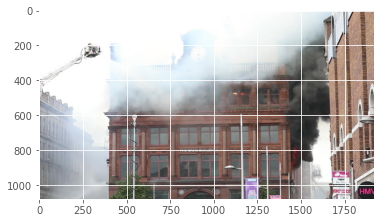

Smoke 94.36390995979309


In [50]:
def app(path):
    img = Image.open(path)
    plt.imshow(img)
    plt.show()

    prediction, prob = predict(img)
    print(prediction, prob)
    

for img_file in os.listdir('./test-imgs/'):
    img_path = os.path.join('./test-imgs/', img_file)
    app(img_path)